# CVRmap paper: figures

## Readme!

The goal of this notebook is to reproduce the figures of the main CVRmap paper.

Instructions to run this notebook can be found at `github.com/ln2t/cvrmap-paper`.

__Beware: you must adapt the following paths for this notebook to work!__

In [ ]:
bids_dir = '/path/to/bids/dataset'
fmriprep_dir = '/path/to/fmriprep/derivatives'
cvrmap_dir = '/path/to/cvrmap/derivatives'

In [1]:
bids_dir = '/mnt/erasme/openneuro/ds004604'
from os.path import join
cvrmap_dir = join(bids_dir, 'derivatives', 'cvrmap')
fmriprep_dir = join(bids_dir, 'derivatives', 'fmriprep')

## Preliminaries

### Imports

In [2]:
import pandas as pd
import numpy as np
import scipy
from plotly import graph_objects as go
from bids import BIDSLayout as bidslayout
import nibabel as nb
from nilearn import plotting, masking, image
from nilearn.glm.second_level import SecondLevelModel

### Bids load

In [34]:
space = 'MNI152NLin2009cAsym'

In [4]:
layout = bidslayout(bids_dir, validate=False)
layout.add_derivatives(cvrmap_dir, validate=False)
layout.add_derivatives(fmriprep_dir, validate=False)

### Fetch data

In [6]:
data_filter = dict(return_type='filename', extension='.nii.gz', space=space)

Get CVR and delay data:

In [14]:
cvr_fn = []
for item in layout.derivatives['cvrmap'].get(**data_filter, suffix='cvr'):
    cvr_fn.append(image.load_img(item))

Harmonize affines (this is necessary if affines are not exactly the same in fmriprep outputs):

In [16]:
cvr_img = []

_ref = cvr_fn[0]
for _img in cvr_fn:
    cvr_img.append(image.resample_to_img(_img, _ref))

In [17]:
delays_fn = []
for item in layout.derivatives['cvrmap'].get(**data_filter, suffix='delay'):
    delays_fn.append(image.load_img(item))

Harmonize affines

In [18]:
delays_img = []

_ref = delays_fn[0]
for _img in delays_fn:
    delays_img.append(image.resample_to_img(_img, _ref))

Extract all masks

In [23]:
brainmask_fn = []
for item in layout.derivatives['fMRIPrep'].get(**data_filter, desc='brain', task='gas', suffix='mask'):
    brainmask_fn.append(image.load_img(item))

Harmonize affines

In [24]:
brainmask_img = []

_ref = brainmask_fn[0]
for _img in brainmask_fn:
    brainmask_img.append(image.resample_to_img(_img, _ref, interpolation='nearest'))

Compute intersection of all masks:

In [25]:
mask_intersection = brainmask_img[0]
for mask in brainmask_img:
    mask_intersection = image.math_img('(img1>0)*img2', img1=mask, img2=mask_intersection)

Load participants.tsv file to extract age:

In [26]:
participants_fn = layout.get(return_type='filename', extension='.tsv', scope='raw')[0]
participants_df = pd.read_csv(participants_fn, sep='\t')

### Some basic data processing

#### Mean corrected for age effect

Normalize the age regressors:

In [27]:
ages = participants_df['age'].values
ages = ages - np.mean(ages)
ages = ages.reshape((-1,1))

Define design matrix with a constant term and age:

In [28]:
design_matrix = pd.DataFrame(
    np.hstack((ages, np.ones_like(ages))),
    columns=['age', 'intercept'])

Fit the model to the CVR and delay data:

In [29]:
cvr_second_level_model = SecondLevelModel(mask_img=mask_intersection, smoothing_fwhm=5).fit(
    cvr_img, design_matrix=design_matrix)

In [30]:
delays_second_level_model = SecondLevelModel(mask_img=mask_intersection, smoothing_fwhm=5).fit(
    delays_img, design_matrix=design_matrix)

Compute the contrasts for the intercept, and extract effect size for each type of data:

In [31]:
cvr_con = cvr_second_level_model.compute_contrast(second_level_contrast='intercept', output_type='effect_size')

In [32]:
delays_con = delays_second_level_model.compute_contrast(second_level_contrast='intercept', output_type='effect_size')

#### CVR by age-group and regressions

In [47]:
tissue_list = ['GM', 'WM', 'CSF']
fn = dict()
tissue_niimg = dict()
tissue_resampled_niimg = dict()
tissue_mask_niimg = dict()
cvr_niimg = dict()
cvr_mean = dict()
cvr_data = dict()
data_filter = dict(return_type='filename', extension='.nii.gz')
label=None
sub_list = sorted(layout.derivatives['cvrmap'].get_subject())

for sub in sub_list:
    for tissue in tissue_list:
        cvr_niimg[sub] = layout.derivatives['cvrmap'].get(**data_filter, label=label, space=space, suffix='cvr', subject=sub)[0]
        fn[(sub, tissue)] = layout.derivatives['fMRIPrep'].get(**data_filter, suffix='probseg', space=None, label=tissue, subject=sub)[0]
        tissue_niimg[(sub, tissue)] = nb.load(fn[(sub, tissue)])
        tissue_resampled_niimg[(sub, tissue)] = image.resample_to_img(tissue_niimg[(sub, tissue)], cvr_niimg[sub], interpolation='nearest')
        tissue_mask_niimg[(sub, tissue)] = image.binarize_img(tissue_resampled_niimg[(sub, tissue)], threshold='95%')
        cvr_data[(sub, tissue)] = masking.apply_mask(cvr_niimg[sub] , tissue_mask_niimg[(sub, tissue)], ensure_finite = False)
        cvr_data[(sub, tissue)] = cvr_data[(sub, tissue)][~np.isnan(cvr_data[(sub, tissue)])]
        cvr_mean[(sub, tissue)] = np.mean(cvr_data[(sub, tissue)])

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array wit

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array wit

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array wit

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array wit

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array wit

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array wit

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array wit

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.

/home/arovai/miniconda3/envs/cvrmap_paper/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array wit

In [49]:
participants_df['age_group'] = np.where(participants_df['age'] < 30, 'Age < 30', np.where(participants_df['age'] > 50, 'Age > 50', '30 < Age < 50'))
for tissue in tissue_list:
    participants_df[tissue] = ""
    for sub in sub_list:
        participants_df.loc[participants_df['participant_id'] == 'sub-' + sub, tissue] = cvr_mean[(sub, tissue)]

In [50]:
x = dict()
y = dict()
stats = dict()

for tissue in tissue_list:
    x[tissue] = participants_df[tissue].values.astype('float')
    y[tissue] = participants_df['age'].values
    stats[tissue] = scipy.stats.linregress(y[tissue], x[tissue])
    print('Results for  %s :' % tissue)
    print(stats[tissue])

Results for  GM :
LinregressResult(slope=6.479746479306377e-05, intercept=0.19072323233580235, rvalue=0.0102179765379999, pvalue=0.9438543308615421, stderr=0.0009152712519374266, intercept_stderr=0.03220688547384891)
Results for  WM :
LinregressResult(slope=0.0001347710037250306, intercept=0.1822920986030993, rvalue=0.021665250281087723, pvalue=0.8812860436212537, stderr=0.0008976565093978685, intercept_stderr=0.03158705174213058)
Results for  CSF :
LinregressResult(slope=0.00018753058019997193, intercept=0.1802084893041983, rvalue=0.029261698598209245, pvalue=0.84013469404284, stderr=0.0009246256448718798, intercept_stderr=0.032536051129690914)


## Figures

### Figure 2 (upper part): GM-CVR and WM-CVR versus age groups (violin plots)

In [51]:
tissue_display_list = ['GM', 'WM']
group_list = ['Age < 30', '30 < Age < 50', 'Age > 50']
fig = go.Figure()
for tissue in tissue_display_list:
    fig.add_trace(go.Violin(y=participants_df[tissue], x=participants_df['age_group'], legendgroup=tissue, scalegroup=tissue, name=tissue))
fig.update_traces(box_visible=False, meanline_visible=True)
fig.update_layout(violinmode='group', plot_bgcolor='white')
fig.update_yaxes(title='CVR (%BOLD/mmHg)')
for group in group_list:
    fig.add_trace(go.Scatter(x=[group], y=[0.5], marker=dict(size=15), mode='markers', marker_symbol='star', marker_line_width=2, marker_color='blue', marker_line_color='blue', showlegend=False))
fig.show()

### Figure 2 (lower part): CVR - age corrected mean

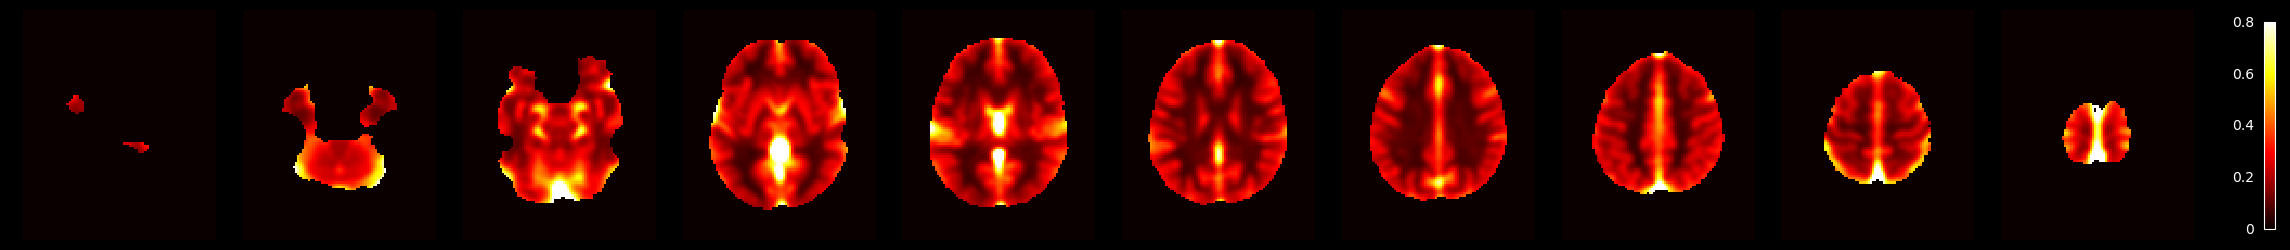

In [52]:
plotting.plot_img(cvr_con, cmap='hot', display_mode='z', black_bg=True, cbar_tick_format="%0.2g",  annotate=False, colorbar=True, vmin=0, vmax=0.8, cut_coords=10)

### Extented Data Figure 3: GM-CVR and WM-CVR versus age, with linear regressions

In [53]:
x_span = np.arange(20,70,1)
font = dict(size=15)

fig = go.Figure()
fig.add_trace(go.Scatter(x=participants_df['age'], y=participants_df['GM'], name='GM (r=-0.39, p=0.5%)', mode='markers', marker=dict(size=10, color='blue')))
fig.add_trace(go.Scatter(x=participants_df['age'], y=participants_df['WM'], name='WM (r=-0.32, p=2.2%)', mode='markers', marker=dict(size=10, color='red')))
fig.add_trace(go.Scatter(x=x_span, y=stats['GM'].intercept + stats['GM'].slope * x_span, name='GM fit', mode='lines', marker=dict(size=10, color='blue'), showlegend=False))
fig.add_trace(go.Scatter(x=x_span, y=stats['WM'].intercept + stats['WM'].slope * x_span, name='WM fit', mode='lines', marker=dict(size=10, color='red'), showlegend=False))
fig.update_layout(plot_bgcolor='white', font=font)
fig.update_yaxes(title='CVR (%BOLD/mmHg)')
fig.update_xaxes(title='age (years)')
fig.update_layout(legend=dict(yanchor="top", xanchor="right", x=0.8, font=font))

### Extended Data Figure 4: Delays - age corrected mean

For visual purposes it is convenient to set voxels outside the mask to 1:

In [54]:
vmax = 1

In [55]:
delays_con_display = image.math_img('np.where(mask, img, %s)' % vmax, img=delays_con, mask=mask_intersection)

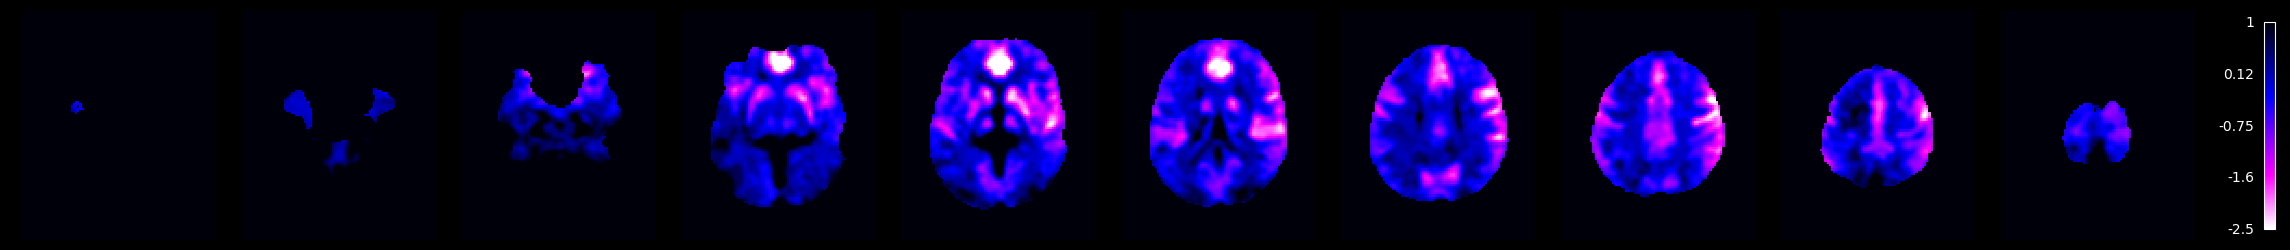

In [58]:
plotting.plot_img(delays_con_display, cmap='black_purple_r', display_mode='z', black_bg=True, cbar_tick_format="%0.2g",  annotate=False, colorbar=True, vmin=-2.5, vmax=vmax, cut_coords=10)